# Imports

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from wordcloud import WordCloud
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split

import random


stop_words = set(stopwords.words('english'))
st = SnowballStemmer('english')

# Loading SMS Data

In [2]:
sms_data = pd.read_csv('raw_data.csv',quotechar='"')
sms_data['text_len'] = sms_data.text.apply(lambda x: len(x))
sms_data['num_words'] = sms_data.text.apply(lambda x: len(x.split(' ')))

In [3]:
sms_data

,label,text,text_len,num_words
0,ham,"Go until jurong point, crazy.. Available only ...",111,20
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28
3,ham,U dun say so early hor... U c already then say...,49,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13
...,...,...,...,...
5569,spam,This is the 2nd time we have tried 2 contact u...,160,30
5570,ham,Will ü b going to esplanade fr home?,36,8
5571,ham,"Pity, * was in mood for that. So...any other s...",57,10
5572,ham,The guy did some bitching but I acted like i'd...,125,26


# Data Analysis

## Text samples

In [4]:
spam_data = sms_data[sms_data.label == "spam"]
ham_data = sms_data[sms_data.label == "ham"]

In [5]:
spam_data.head(n=10)

,label,text,text_len,num_words
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28
5,spam,FreeMsg Hey there darling it's been 3 week's n...,147,32
8,spam,WINNER!! As a valued network customer you have...,157,26
9,spam,Had your mobile 11 months or more? U R entitle...,154,29
11,spam,"SIX chances to win CASH! From 100 to 20,000 po...",136,26
12,spam,URGENT! You have won a 1 week FREE membership ...,155,26
15,spam,"XXXMobileMovieClub: To use your credit, click ...",149,19
19,spam,England v Macedonia - dont miss the goals/team...,155,24
34,spam,Thanks for your subscription to Ringtone UK yo...,158,29
42,spam,07732584351 - Rodger Burns - MSG = We tried to...,172,33


In [6]:
ham_data.head(n=10)

,label,text,text_len,num_words
0,ham,"Go until jurong point, crazy.. Available only ...",111,20
1,ham,Ok lar... Joking wif u oni...,29,6
3,ham,U dun say so early hor... U c already then say...,49,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13
6,ham,Even my brother is not like to speak with me. ...,77,16
7,ham,As per your request 'Melle Melle (Oru Minnamin...,160,26
10,ham,I'm gonna be home soon and i don't want to tal...,109,21
13,ham,I've been searching for the right words to tha...,196,37
14,ham,I HAVE A DATE ON SUNDAY WITH WILL!!,35,8
16,ham,Oh k...i'm watching here:),26,4


## Checking class imbalance

In [7]:
sms_data.groupby('label').describe()

text_len                                                           \
         count        mean        std   min    25%    50%    75%    max   
label                                                                     
ham     4827.0   71.471929  58.326643   2.0   33.0   52.0   93.0  910.0   
spam     747.0  138.676037  28.871250  13.0  133.0  149.0  157.0  223.0   

      num_words                                                      
          count       mean        std  min   25%   50%   75%    max  
label                                                                
ham      4827.0  14.427595  11.614967  1.0   7.0  11.0  19.0  171.0  
spam      747.0  23.953146   5.794904  2.0  22.0  25.0  28.0   35.0

In [8]:
sms_data[['label','text']].groupby('label').describe()

text                                                               
      count unique                                                top freq
label                                                                     
ham    4827   4518                             Sorry, I'll call later   30
spam    747    653  Please call our customer service representativ...    4

## Message length distribution

array([<Axes: title={'center': 'ham'}>, <Axes: title={'center': 'spam'}>],
      dtype=object)

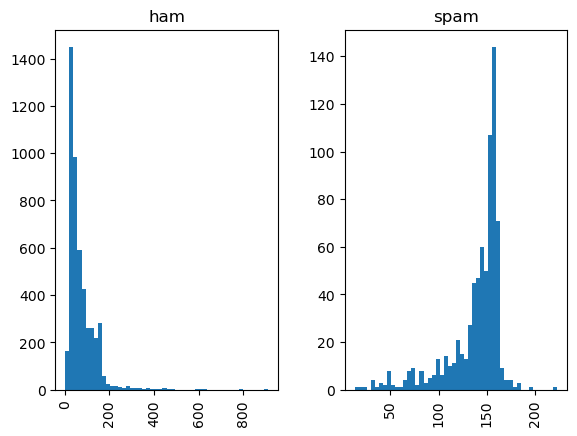

In [9]:
sms_data.hist(column='text_len', by='label', bins=50)

In [10]:
sms_data.text_len.describe()

count    5574.000000
mean       80.478292
std        59.848302
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: text_len, dtype: float64

In [11]:
sms_data[sms_data.text_len > 450]

,label,text,text_len,num_words
1085,ham,For me the love should start with attraction.i...,910,171
1513,ham,"Hey sweet, I was wondering when you had a mome...",458,95
1579,ham,How to Make a girl Happy? It's not at all diff...,611,121
1863,ham,The last thing i ever wanted to do was hurt yo...,790,162
2158,ham,Sad story of a Man - Last week was my b'day. M...,588,125
2380,ham,"Good evening Sir, hope you are having a nice d...",482,99
2434,ham,Indians r poor but India is not a poor country...,629,119
2849,ham,Sad story of a Man - Last week was my b'day. M...,588,125
3017,ham,"&lt;#&gt; is fast approaching. So, Wish u a v...",461,69


## Word distribution

In [12]:
def trim_spaces(x):
    # change to lower and remove spaces on either side
    x = x.lower().strip()
    # remove extra spaces in between
    return re.sub(' +', ' ', x)
    
def remove_punctuation(x):
    return re.sub('[^a-zA-Z]', ' ', x)

def clean_text(x, remove_stopwords=True, get_stem=True):
    x = remove_punctuation(trim_spaces(x))
    #tokenize words in text
    x = word_tokenize(x)
   
    # remove stopwords
    if remove_stopwords:
        if get_stem:
            x = ' '.join(st.stem(text) for text in x if text not in stop_words)
        else:
            x = ' '.join(text for text in x if text not in stop_words)
    
    return x

In [13]:
spam_all_words = " ".join(spam_data.text.apply(clean_text,get_stem=False))
spam_counter = pd.Series(spam_all_words.split(' ')).value_counts()

ham_all_words = " ".join(ham_data.text.apply(clean_text,get_stem=False))
ham_counter = pd.Series(ham_all_words.split(' ')).value_counts()

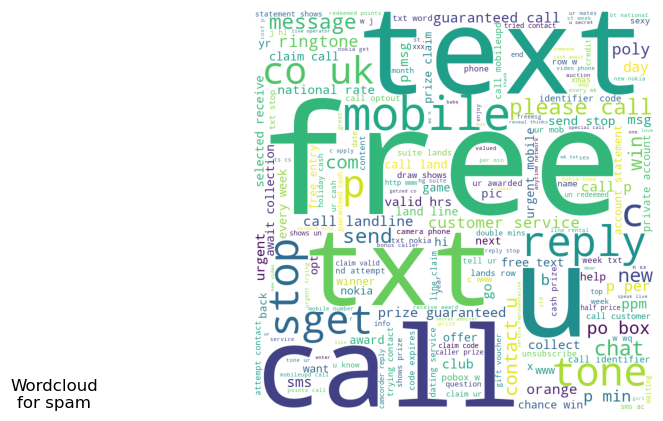

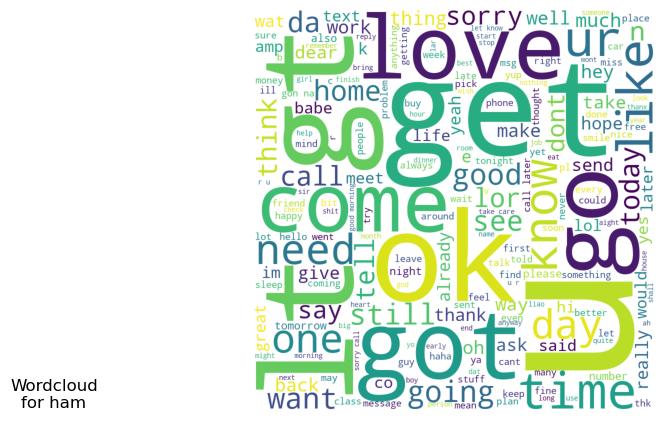

In [14]:
def generate_wordcloud(all_words, caption=""):
    wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stop_words,
                min_font_size = 10).generate(all_words)
 
    # plot the WordCloud image                       
    plt.figure(figsize = (4, 4), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.figtext(-0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=12)
     
    plt.show()

generate_wordcloud(spam_all_words, "Wordcloud for spam")
generate_wordcloud(ham_all_words, "Wordcloud for ham")

In [15]:
spam_counter

call     370
free     228
u        186
p        180
txt      170
        ... 
bb         1
fifa       1
world      1
held       1
house      1
Name: count, Length: 1990, dtype: int64

In [16]:
ham_counter

u            1042
gt            318
lt            316
get           311
ok            288
             ... 
howda           1
mathe           1
samachara       1
audrie          1
bitching        1
Name: count, Length: 6612, dtype: int64

# Data Preprocessing

## Clean text

In [17]:
sms_data["cleaned_text"] = sms_data.text.apply(clean_text)
sms_data.cleaned_text

0       go jurong point crazi avail bugi n great world...
1                                   ok lar joke wif u oni
2       free entri wkli comp win fa cup final tkts st ...
3                     u dun say earli hor u c alreadi say
4                    nah think goe usf live around though
                              ...                        
5569    nd time tri contact u u pound prize claim easi...
5570                                b go esplanad fr home
5571                                    piti mood suggest
5572    guy bitch act like interest buy someth els nex...
5573                                       rofl true name
Name: cleaned_text, Length: 5574, dtype: object

# Main Content: Assignment 2

In [18]:
!git checkout -b a2
!git add .
!git commit -m "Adding files from Assignment 1 and adding raw_data as specified in the description for Assignment 2"

fatal: a branch named 'a2' already exists


[a2 3e6f52d] Adding files from Assignment 1 and adding raw_data as specified in the description for Assignment 2
 2 files changed, 541 insertions(+), 41 deletions(-)


## Setup DVC

In [19]:
!dvc init --no-scm
!git add .
!git commit -m "Initialize DVC"

Initialized DVC repository.

+---------------------------------------------------------------------+
|                                                                     |
|        DVC has enabled anonymous aggregate usage analytics.         |
|     Read the analytics documentation (and how to opt-out) here:     |
|             <https://dvc.org/doc/user-guide/analytics>              |
|                                                                     |
+---------------------------------------------------------------------+

What's next?
------------
- Check out the documentation: <https://dvc.org/doc>
- Get help and share ideas: <https://dvc.org/chat>
- Star us on GitHub: <https://github.com/iterative/dvc>
[a2 d977731] Initialize DVC
 3 files changed, 5 insertions(+)
 create mode 100644 Assignment 2/.dvc/config
 create mode 100644 Assignment 2/.dvc/tmp/btime
 create mode 100644 Assignment 2/.dvcignore


## Setup Remote DVC in Google Drive

DVC remote gdrive link: https://drive.google.com/drive/folders/1g6qxjyDsyhbiEB76BCzJbHpVlKr3G9ty

In [20]:
!dvc remote add --default myremote gdrive://1g6qxjyDsyhbiEB76BCzJbHpVlKr3G9ty
!dvc remote modify myremote gdrive_client_id 801419145696-73d8ge5coqg85qgfhurie9a16bmtn4pr.apps.googleusercontent.com
!dvc remote modify myremote gdrive_client_secret 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
!dvc remote modify myremote gdrive_service_account_user_email \
              shajaganbpgc@gmail.com
!dvc remote modify myremote gdrive_acknowledge_abuse true
!dvc push

Setting 'myremote' as a default remote.
Everything is up to date.


## Generate Train, Test, Validation Data

Using 70% for Train, 10% for Validation and 20% for testing

In [21]:
random_seed = random.randint(0, 10000)

train, rest = train_test_split(sms_data, test_size=0.3,stratify=sms_data.label,random_state=random_seed)
test, val = train_test_split(rest, test_size=(1/3),stratify=rest.label,random_state=random_seed)

## Storing splits into CSV files

In [22]:
train.to_csv('train.csv',index=False)
val.to_csv('validation.csv',index=False)
test.to_csv('test.csv',index=False)

## Track data using DVC and set a git commit with version 

In [47]:
!dvc add raw_data.csv
!dvc add train.csv
!dvc add validation.csv
!dvc add test.csv

!dvc push

\u280b Checking graph

\u280b Checking graph

\u280b Checking graph

\u280b Checking graph

ERROR: unexpected error - Failed to authenticate GDrive: Access token refresh failed: invalid_grant: Bad Request

Having any troubles? Hit us up at https://dvc.org/support, we are always happy to help!


In [33]:
!git add .
!git commit -m "Data Version 1"

[a2 55e8f16] Data Version 1
 3 files changed, 17 insertions(+), 39 deletions(-)


## Regenerating data using different seed for version 2

In [35]:
random_seed = random.randint(0, 10000)

train, rest = train_test_split(sms_data, test_size=0.3,stratify=sms_data.label,random_state=random_seed)
test, val = train_test_split(rest, test_size=(1/3),stratify=rest.label,random_state=random_seed)

train.to_csv('train.csv',index=False)
val.to_csv('validation.csv',index=False)
test.to_csv('test.csv',index=False)

In [39]:
# !dvc commit -f
!dvc push

ERROR: unexpected error - Failed to authenticate GDrive: Access token refresh failed: invalid_grant: Bad Request

Having any troubles? Hit us up at https://dvc.org/support, we are always happy to help!


In [ ]:
!git add .
!git commit -m "Data Version 2"

In [21]:
def print_target_distribution(pth):
    data = pd.read_csv(pth)
    distribution = data['label'].value_counts()
    print(f"Distribution in {os.path.basename(pth)}:")
    print(distribution)

##### Checkout the first version (before update)

In [ ]:
git 
!dvc checkout

In [ ]:
print("Version 1 (Before Update):")
print_target_distribution('train.csv')
print_target_distribution('validation.csv')
print_target_distribution('test.csv')

# Checkout the updated version
!dvc checkout
print("Version 2 (Updated):")
print_target_distribution('train.csv')
print_target_distribution('validation.csv')
print_target_distribution('test.csv')